In [1]:
import sys
sys.path.append('.../')
from functions import model_general as mg
from functions import model_plot as mp
from functions import model_gufuncs as mgpu
from functions import model_mcmc as mmcmc

import matplotlib.pyplot as plt
plt.style.use('lexi_plt_style.mplstyle')

import numpy as np
import corner

We want to use a model to extract out the characteristic seed polymerization for each seed type using our length distribution histograms. To do this we will need to minimize $\chi^2$ relative to each fit parameter. In general $\chi^2$ is given by:

\begin{align*}
     \chi^2 = \frac{1}{n_{num}} \sum_{n=1}^{n_{tot}} \frac{(\textrm{data}_n - \textrm{model}_n)^2}{\textrm{variance}_n}
\end{align*}

where $n_{num}$ is the number of bins used.

First lets represent our $\text{data}_n$ vector as a histogram

https://stats.stackexchange.com/questions/214287/calculating-uncertainties-for-histogram-bins-of-experimental-data-with-known-mea

We will also need to find the error of each histogram bin height. Typically this would just be $\sqrt{n}$ where $n$ is the count of each bin, but we also have a measurement error, associated with the resolution limit of the microscope, that we want to propagate through to the histogram errors.

The standard error of the $j$ bin is given by 
\begin{align*}
    \sum_{i=1}^{n} = p_i(j)(1-p_i(j))
\end{align*}

where $n$ is the number of tubes in that bin and $p_i(j)$ is the probability of the $i$ tube being located in the $j$ bin
\begin{align*}
    p_i(j) = \int_{\text{bin start}}^{\text{bin end}} \frac{1}{\sqrt{2 \pi} \sigma_i} e^{-\frac{(x_i - z)^2}{2\sigma_i^2}} dz
\end{align*}

where $\sigma_i$ is the measurement error of each observation $i$, which for us is constant

In [2]:
#generate data_dict.json
#exec(open('scripts/get_data_dict.py').read())

In [3]:
seed_len_types = [ 'p3024', 's768', 's576', 's384']
pixel_per_um = 15.4792

bins = [1 + i*0.5 for i in range(0,30)] #use the same bins for all plots
x_data = np.array([j+0.25 for j in bins[0:-1]]) #get x data points from the bins (center point of each bin)
colors = ['r', 'b', 'violet', 'orange']
mes_error = 8/pixel_per_um

len_dicts = mg.get_os_length_dicts(seed_len_types)
not_norm_y_data_sets = []
for i in range(len(seed_len_types)):
    not_norm_data, _ = np.histogram(len_dicts[i], bins = bins)
    not_norm_y_data_sets.append(not_norm_data)
not_norm_y_error_sets = [mg.find_bin_count_error(len_dicts[i], x_data, mes_error) for i in range(len(seed_len_types))]


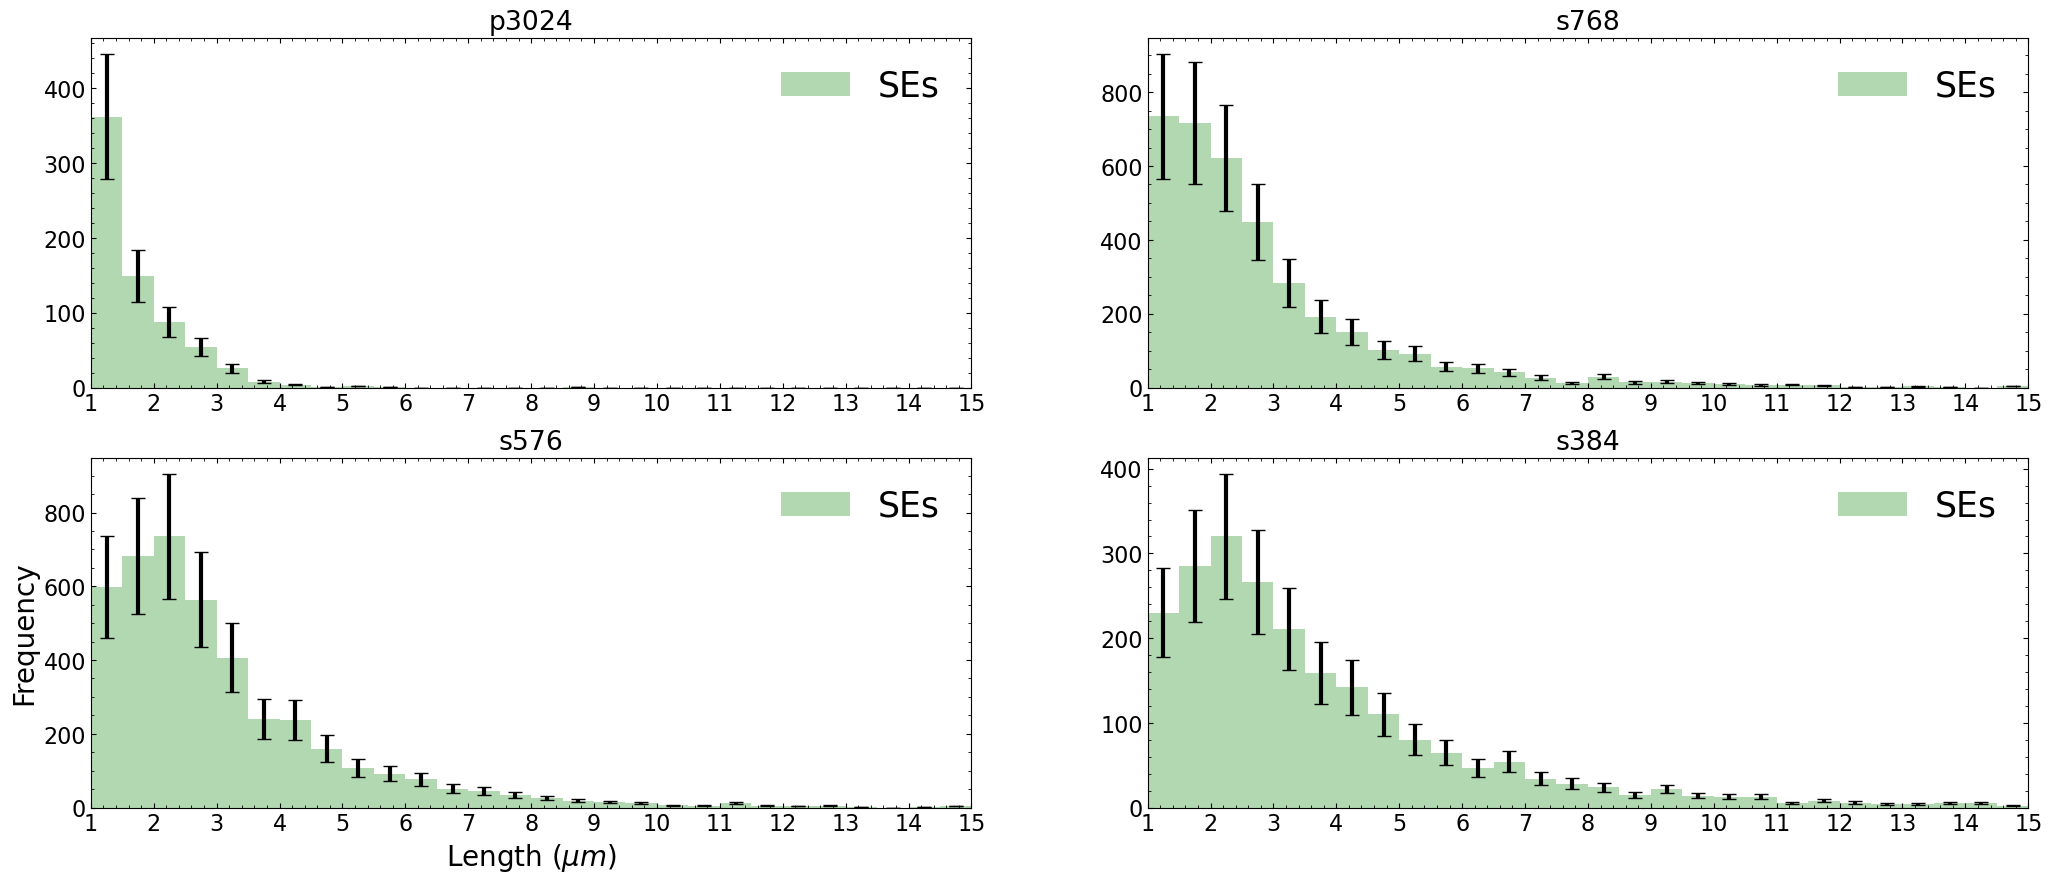

In [4]:
fig, axs = plt.subplots(2,2, figsize = (25,10))
mp.plot_hist(x_data, not_norm_y_data_sets, not_norm_y_error_sets, axs, seed_len_types, norm = False)
plt.show()

Rather than plotting a basic histogram, we want to plot the normalized frequency. To normalize we need to just divide each count by the area under the curve, which we will get by multiplying the width of each bin, by its count.

\begin{align*}
    A &= \sum_{i=1}^{n_{max}} width_i  N_i \\
    &= width \sum_{n=1}^{n_{max}} N_i
\end{align*}

but we need to propagate the error in each bin before normalization into the final error for each bin

\begin{align*}
    y_{norm} &= \frac{y}{A} \\
    \frac{\partial y_{norm}}{\partial A} &= -y (A)^{-2} \\
    \delta y_{norm} &= \sqrt{\left(\frac{\partial y_{norm}}{\partial A}\right)^2 (\delta A)^2} \\
    &= \frac{y \delta A}{A^2}
\end{align*}

where $\delta A$ is the error in the area under the curve which is given by
\begin{align*}
\delta A &= \sqrt{\sum_{i=1}^{n_{max}} \left(\frac{\delta A}{\delta N_i}\right)^2 \delta N_i^2} \\
&= width \sqrt{\sum_{i=1}^{n_{max}} \delta N_i^2}
\end{align*}

In [5]:
y_data_sets = [mg.get_ydata(len_dicts[i], bins, x_data) for i in range(len(seed_len_types))]
y_error_sets = [mg.get_yerror(len_dicts[i], bins, x_data, mes_error) for i in range(len(seed_len_types))]

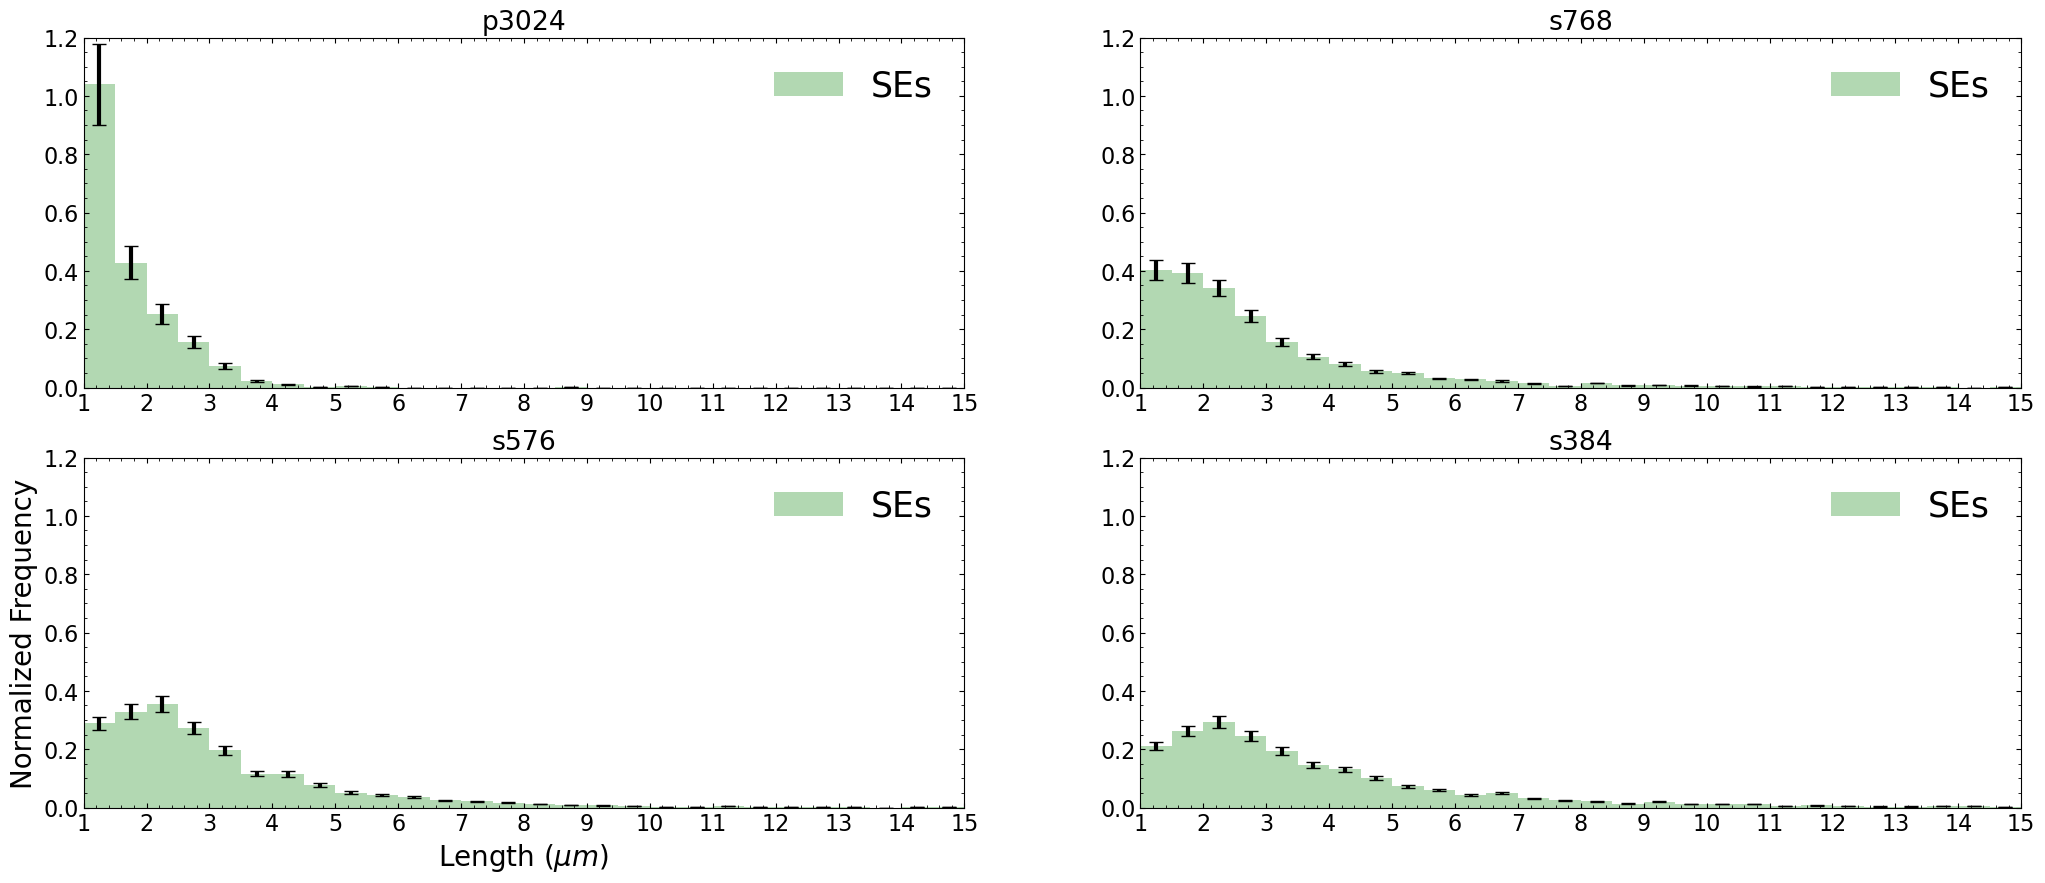

In [6]:
fig, axs = plt.subplots(2,2, figsize = (25,10))
mp.plot_hist(x_data, y_data_sets, y_error_sets, axs, seed_len_types)
plt.show()

Now that we have our data and variance vectors, we need to describe our model so that we can create our model vector. The model we are using is describe in this paper: A coarse-grained model captures the temporal evolution of DNA nanotube length distributions

This models the behavior of a histogram of the length distribution over time, rather than the entire length distribution. The larger the bin width, the more coarse grain the model is.

After making the following assumptions:
- we are not changing the tile concentration over time so $a(t) = d(t) = 0$
- $k_{break}$ is constant (they also make this assumption in their paper when they fit)
- all of our nucleation sites $[L_0]$ are seeds rather than forming from spontaneous nucleation
- therefore the characteristic nucleation site size is equal to the size of the seed in tiles (64, 18, 14, 9 for p3024, s769, s567, and s384)
- we are working at low enough tile concentrations that no spontaneous nucleation occurs aka $k_{nucl} = 0$
- the nucli (our seeds) are not unfolding aka $k_{d_0} = 0$
- no end to end joining b/c non-homogenous tubes cannot join

Since our histogram bins are $0.5\mu m$ wide and we have 29 of them in total: 
- $N_b$ = 420 tiles
- $l_b$ = 0.5 $\mu m$
- $d$ = 13 nm
- $n_{max}$ = 29

The free tile concentration is described with one ODE: 

\begin{align*}
    \frac{d[T]}{dt} &= - N_b k_p [T] \sum_{i = 1}^{n_{max} -1} [L_i] - (Nb - N_{nucl}) k_{p_0} [T] [L_0] + N_b k_d \sum_{i=2}^{n_{max}} [L_i] + (N_b - N_{nucl}) k_d [L_1] 
\end{align*}

where $N_{nucl}$ is the characteristic size of a nucleation site (how many tiles have to come together at once to create a nucleation site), $N_b$ is the bin width in number of tiles (how many tiles a tube would need to grow to move from one bin to another), $k_p$ is the rate of polymerization, $k_{p_0}$ is the rate of polymerization from a nucleation site, and $k_d$ is the rate of depolymerization.

Then the concentration of nucleation sites $[L_0]$ is described by another ODE.

\begin{align*}
    \frac{d[L_0]}{dt} &= - k_{p_0} [T] [L_0] + k_d [L1]
\end{align*}

Finally the concentration of the $i$ th bin in the histogram $[L_i]$ is described with a system of ODEs.

\begin{align*}
    \frac{d[L_1]}{dt} &= k_{p_0} [T] [L_0] - k_p [T] [L_1] + k_d [L_2] - k_d [L_1] + 2 \sum_{m=2}^{n_{max}} k_{break} [L_m] \\
    \frac{d[L_n]}{dt} &= k_p [T] ([L_{n-1}] - [L_{n|n \leq n_{max}}]) + k_d ([L_{n+1|n \leq n_{max}}] - [L_n]) + 2 \sum_{m \geq n+1}^{n_{max}} k_{break} [L_m] - (n-1) k_{break} [L_n]
\end{align*}

Where $k_{break}$ is the rate of a tube breaking into 2 tubes of different sizes.

Which we can write in terms of the partial derivatives 
\begin{align*}
    \frac{d[T]}{dt} &= k_p \frac{\partial}{\partial k_p} \frac{d[T]}{dt} + k_{p0} \frac{\partial}{\partial k_{p_0}} \frac{d[T]}{dt} + k_d \frac{\partial}{\partial k_d} \frac{d[T]}{dt} \\
    \frac{d[L_0]}{dt} &= k_{p0} \frac{\partial}{\partial k_{p_0}} \frac{d[L_0]}{dt} + k_d \frac{\partial}{\partial k_d} \frac{d[L_0]}{dt} \\
    \frac{d[L_1]}{dt} &= k_{p0} \frac{\partial}{\partial k_{p_0}} \frac{d[L_1]}{dt} - k_p \frac{\partial}{\partial k_p} \frac{d[L_1]}{dt} + k_d \frac{\partial}{\partial k_d} \frac{d[L_1]}{dt} + k_{break} \frac{\partial}{\partial k_{break}} \frac{d[L_1]}{dt}\\
    \frac{d[L_n]}{dt} &= k_p \frac{\partial}{\partial k_p} \frac{d[L_n]}{dt} + k_d \frac{\partial}{\partial k_d} \frac{d[L_n]}{dt} + k_{break} \frac{\partial}{\partial k_{break}} \frac{d[L_n]}{dt}
\end{align*}


In [7]:
Nb = np.int32(420)
bin_width = 0.5
d = 13.0
t_len = 24.0 * 60.0 * 60.0
num_steps = np.int32(100000)
n_max = np.int32(29)
h = np.float32(t_len/num_steps)
Si = np.float32(0.3 * 10**(-9)) #initial seed concentration 0.3nM
Ti = np.float32(100 * 10**(-9)) #initial tile concentration 100nM
N_nucls = np.array([64, 18, 14, 9])

In [8]:
initial_guess_parr = np.array([[1*(10**6), 1*10**6, 1*10**(-7),10**(-8)], 
                    [1*(10**6), 7*(10**4), 1*10**(-7),10**(-8)],
                    [1*(10**6), 5*(10**4), 1*10**(-7),10**(-8)],
                    [1*(10**6), 3*(10**4), 1*10**(-7),10**(-8)]], dtype = np.float64)

In [9]:
L_mat0s = mgpu.get_L_mat(initial_guess_parr, N_nucls, Nb, n_max, num_steps, h, Ti, Si)
L_vec0s = [L_mat[0] for L_mat in L_mat0s]
model0s = [L_vec[1:n_max + 1] / mg.find_area_under_curve(x_data, L_vec[1:n_max + 1]) for L_vec in L_vec0s]

c:\Users\webst\anaconda3\Lib\site-packages\numba\cuda\dispatcher.py:536: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


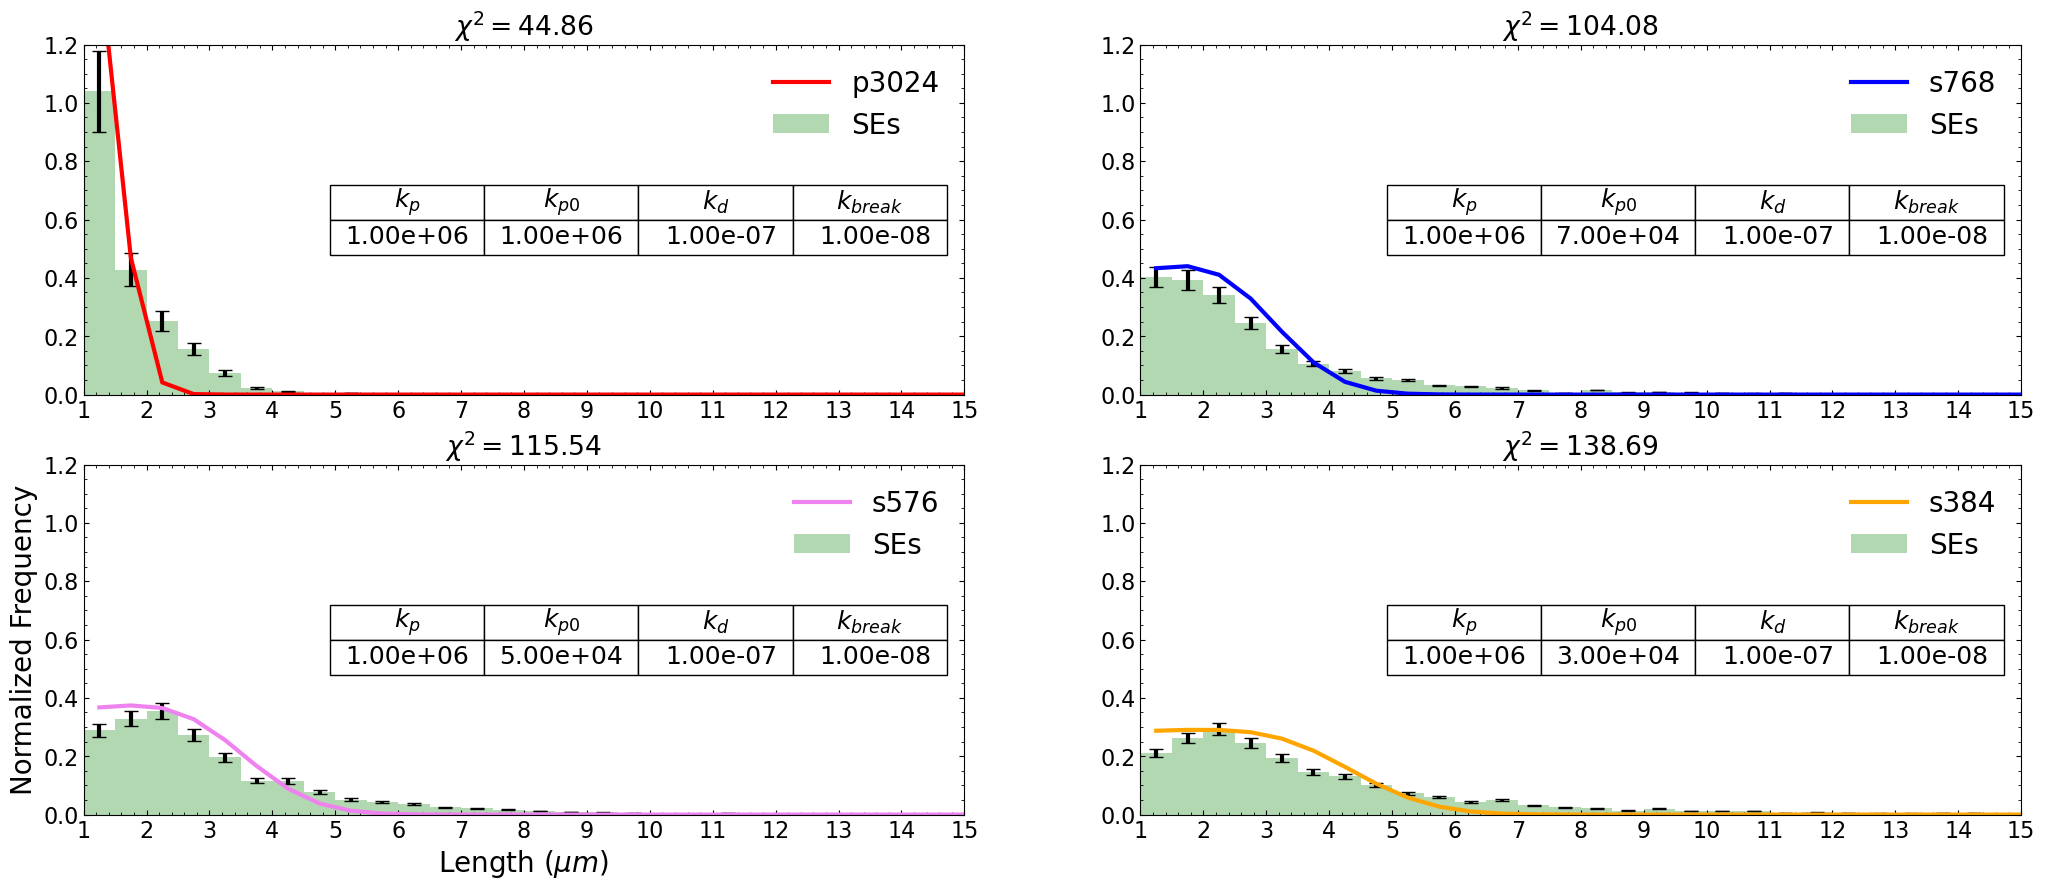

In [10]:
fig, axs = plt.subplots(2,2, figsize = (25,10))
mp.plot_hist(x_data, y_data_sets, y_error_sets, axs, seed_len_types)
mp.plot_model_results(initial_guess_parr, model0s, x_data, y_data_sets, y_error_sets, axs, colors, seed_len_types, n_max)
plt.show()

Before we try to find the best fit parameters, lets get an idea of what the posteier distribution looks like using a Monte Chain Monte Carlo, as it turns out to be very messy.
To do this we need log of the likelihood:

\begin{align*}
    \ln(\mathcal{L}) = -\frac{1}{2} \chi^2
\end{align*}

In [17]:
sigma_guess = np.array([1e4, 1e4, 1e-7, 1e-9], dtype=np.float64)
samples = mmcmc.run_mcmc(2000, 100, 4, initial_guess_parr[0], sigma_guess, N_nucls[0], L_mat0s[0], Nb, n_max, num_steps, h, Ti, Si, x_data, y_data_sets[0], y_error_sets[0])

c:\Users\webst\Documents\Mini Seed Models\functions\model_mcmc.py:49: RuntimeWarning: overflow encountered in exp
  p_to_accept = np.exp(new_lls[walk] - position_lls[walk])


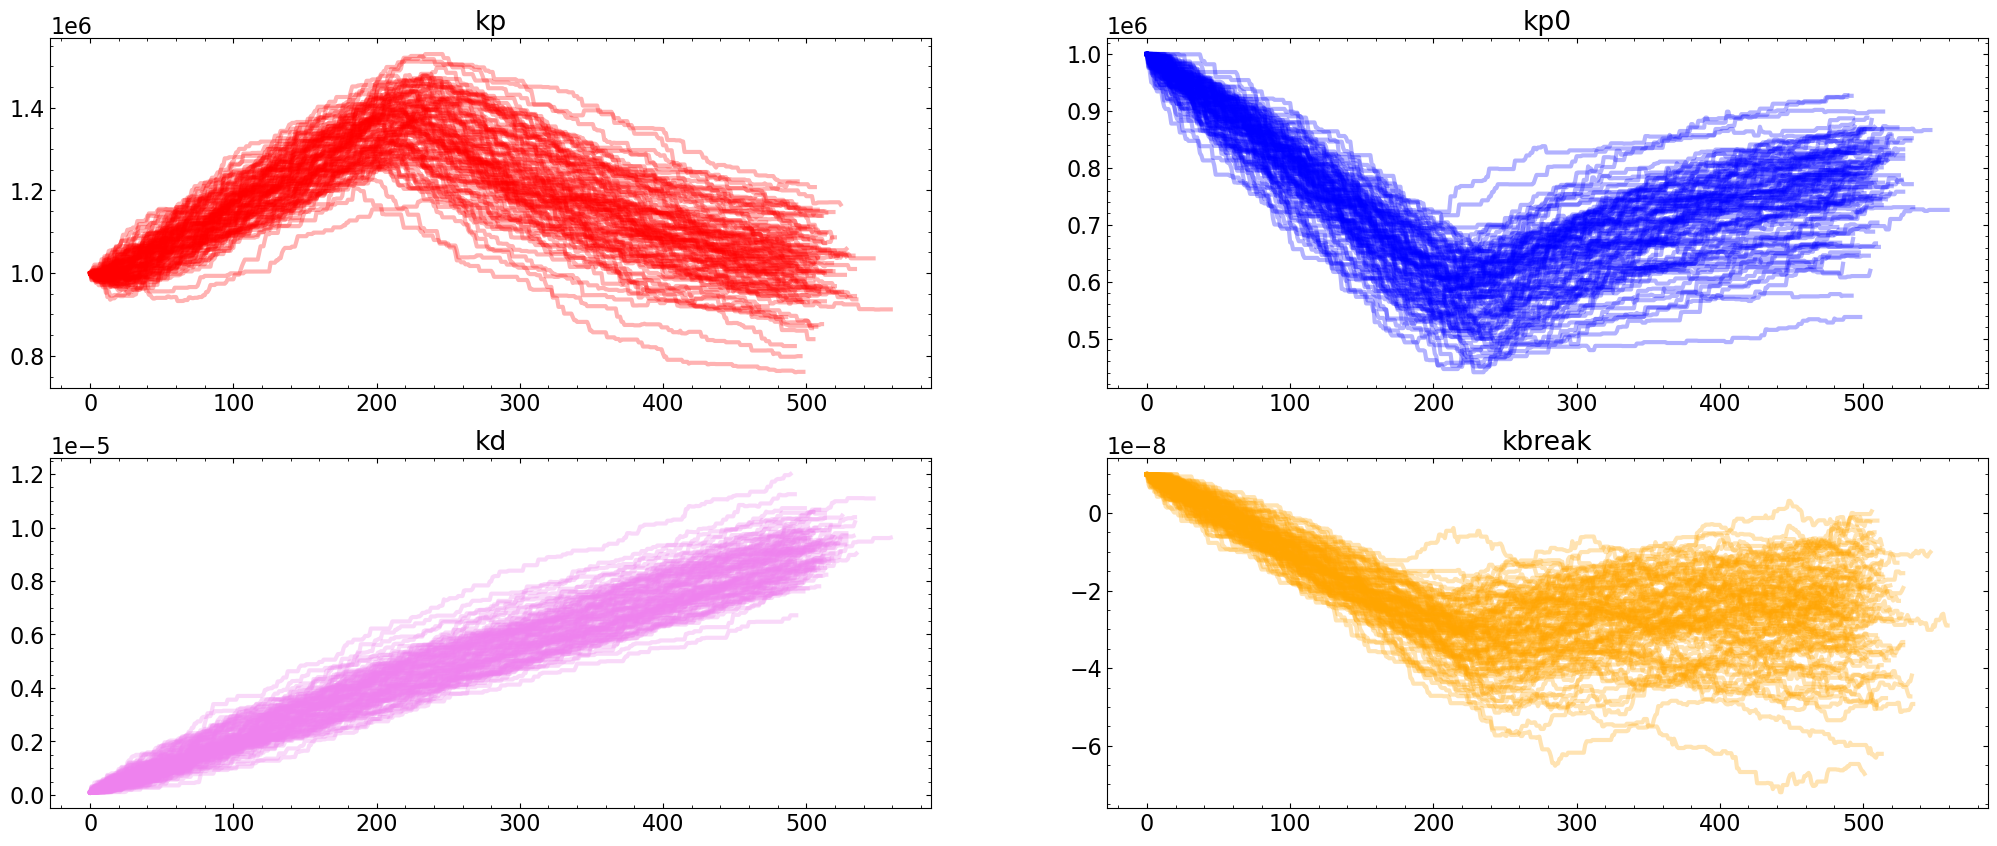

In [15]:
mmcmc.plot_chains(samples)

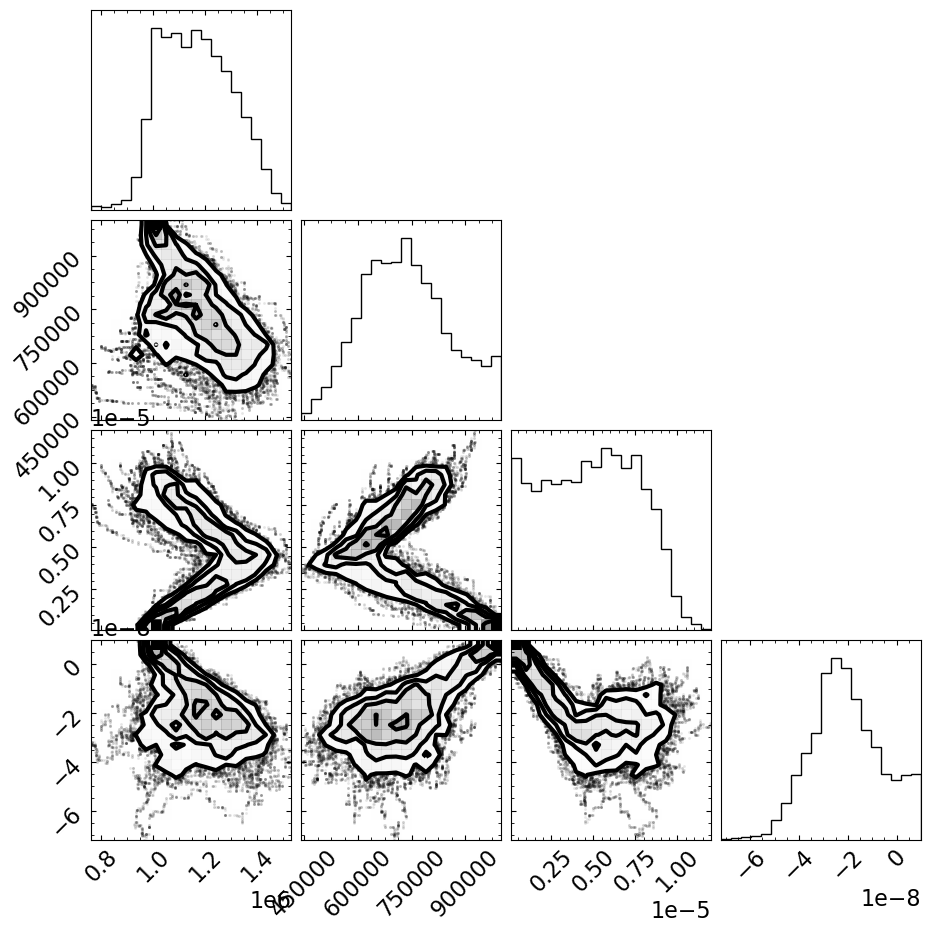

In [16]:
corner.corner(mmcmc.flatten_chains(samples));